# Light-sheet fluorescence microscopy

See section 2.4 in the paper for full results.

The data we use in this notebook was taken with a light-sheet fluorescence microscope.

The full resolution images require a fair bit of memory and can be a bit slow (~20 min for full deconvolution with a GPU).

## Setup

Here we import some necessary packages/helper functions

In [1]:
%load_ext autoreload
%autoreload 2
!export CUDA_VISIBLE_DEVICES=0,1,2,3 # REPLACE this line according to your GPUs

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3" # REPLACE this line according to your GPUs

import sys
sys.path.append("..") # since the package is one level above. Normally you should keep them on the same!
import rdmpy

# here are some basics we will need for the demo
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.measure import block_reduce

from skimage import io
from skimage.transform import resize
from PIL import Image
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 500

# REPLACE this in according to your computer, we highly recommend using a GPU.
# We needed ~20GB of GPU memory to run at full resolution (1024 x 1024).
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
    
    
print('Using ' +str(device) + ' for computation')

def plot_3d_projections(volume, spacing=10):
    """
    Plots the maximum intensity projections of a 3D volume along the y, x, and z axes.
    Projections are arranged with space between them, preserving aspect ratios.
    
    Parameters:
        volume (numpy.ndarray): A 3D numpy array with axes ordered as (y, x, z).
        spacing (int): Space (in pixels) between the plots.
    """
    # Compute the max projections
    z_projection = np.max(volume, axis=2)  # z-projection (center square image)
    y_projection = np.max(volume, axis=0).T  # y-projection (rectangular image below)
    x_projection = np.max(volume, axis=1)  # x-projection (rectangular image to the right)

    # Get dimensions
    z_height, z_width = z_projection.shape  # (y, x)
    y_height, y_width = y_projection.shape  # (x, z)
    x_height, x_width = x_projection.shape  # (y, z)

    # Canvas dimensions
    canvas_height = z_height + spacing + y_height  # Top (z-projection) + spacing + Bottom (y-projection)
    canvas_width = z_width + spacing + x_width  # Left (z-projection) + spacing + Right (x-projection)

    # Create a blank canvas
    canvas = np.ones((canvas_height, canvas_width))

    canvas[0:z_height, 0:z_width] = z_projection
    canvas[z_height + spacing:, :y_width] = y_projection
    canvas[:x_height, z_width + spacing:] = x_projection

    # Plot the result
    #plt.figure(figsize=(10, 10 * canvas_height / canvas_width))
    plt.imshow(canvas, cmap='gray')
    plt.axis('off')
    plt.title("Max Projections")
    plt.show()


def crop(img, c):
    return img[c:-c,c:-c,c:-c]


/home/amit/micromamba/envs/psf/lib/python3.12/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


Using cuda:0 for computation


## One-time Calibration

We calibrate with randomly scattered beads embedded in agarose. Notice how the beads extend in z extent as they move away from the center (along the y-axis).

In [ ]:
base_dir='' # Set this to the data dir if you aren't keeping it in the same folder as this notebook

<tifffile.TiffFile '1_CH01_000000.tif'> OME series failed to read '1_CH00_000000.tif'. Missing data are zeroed


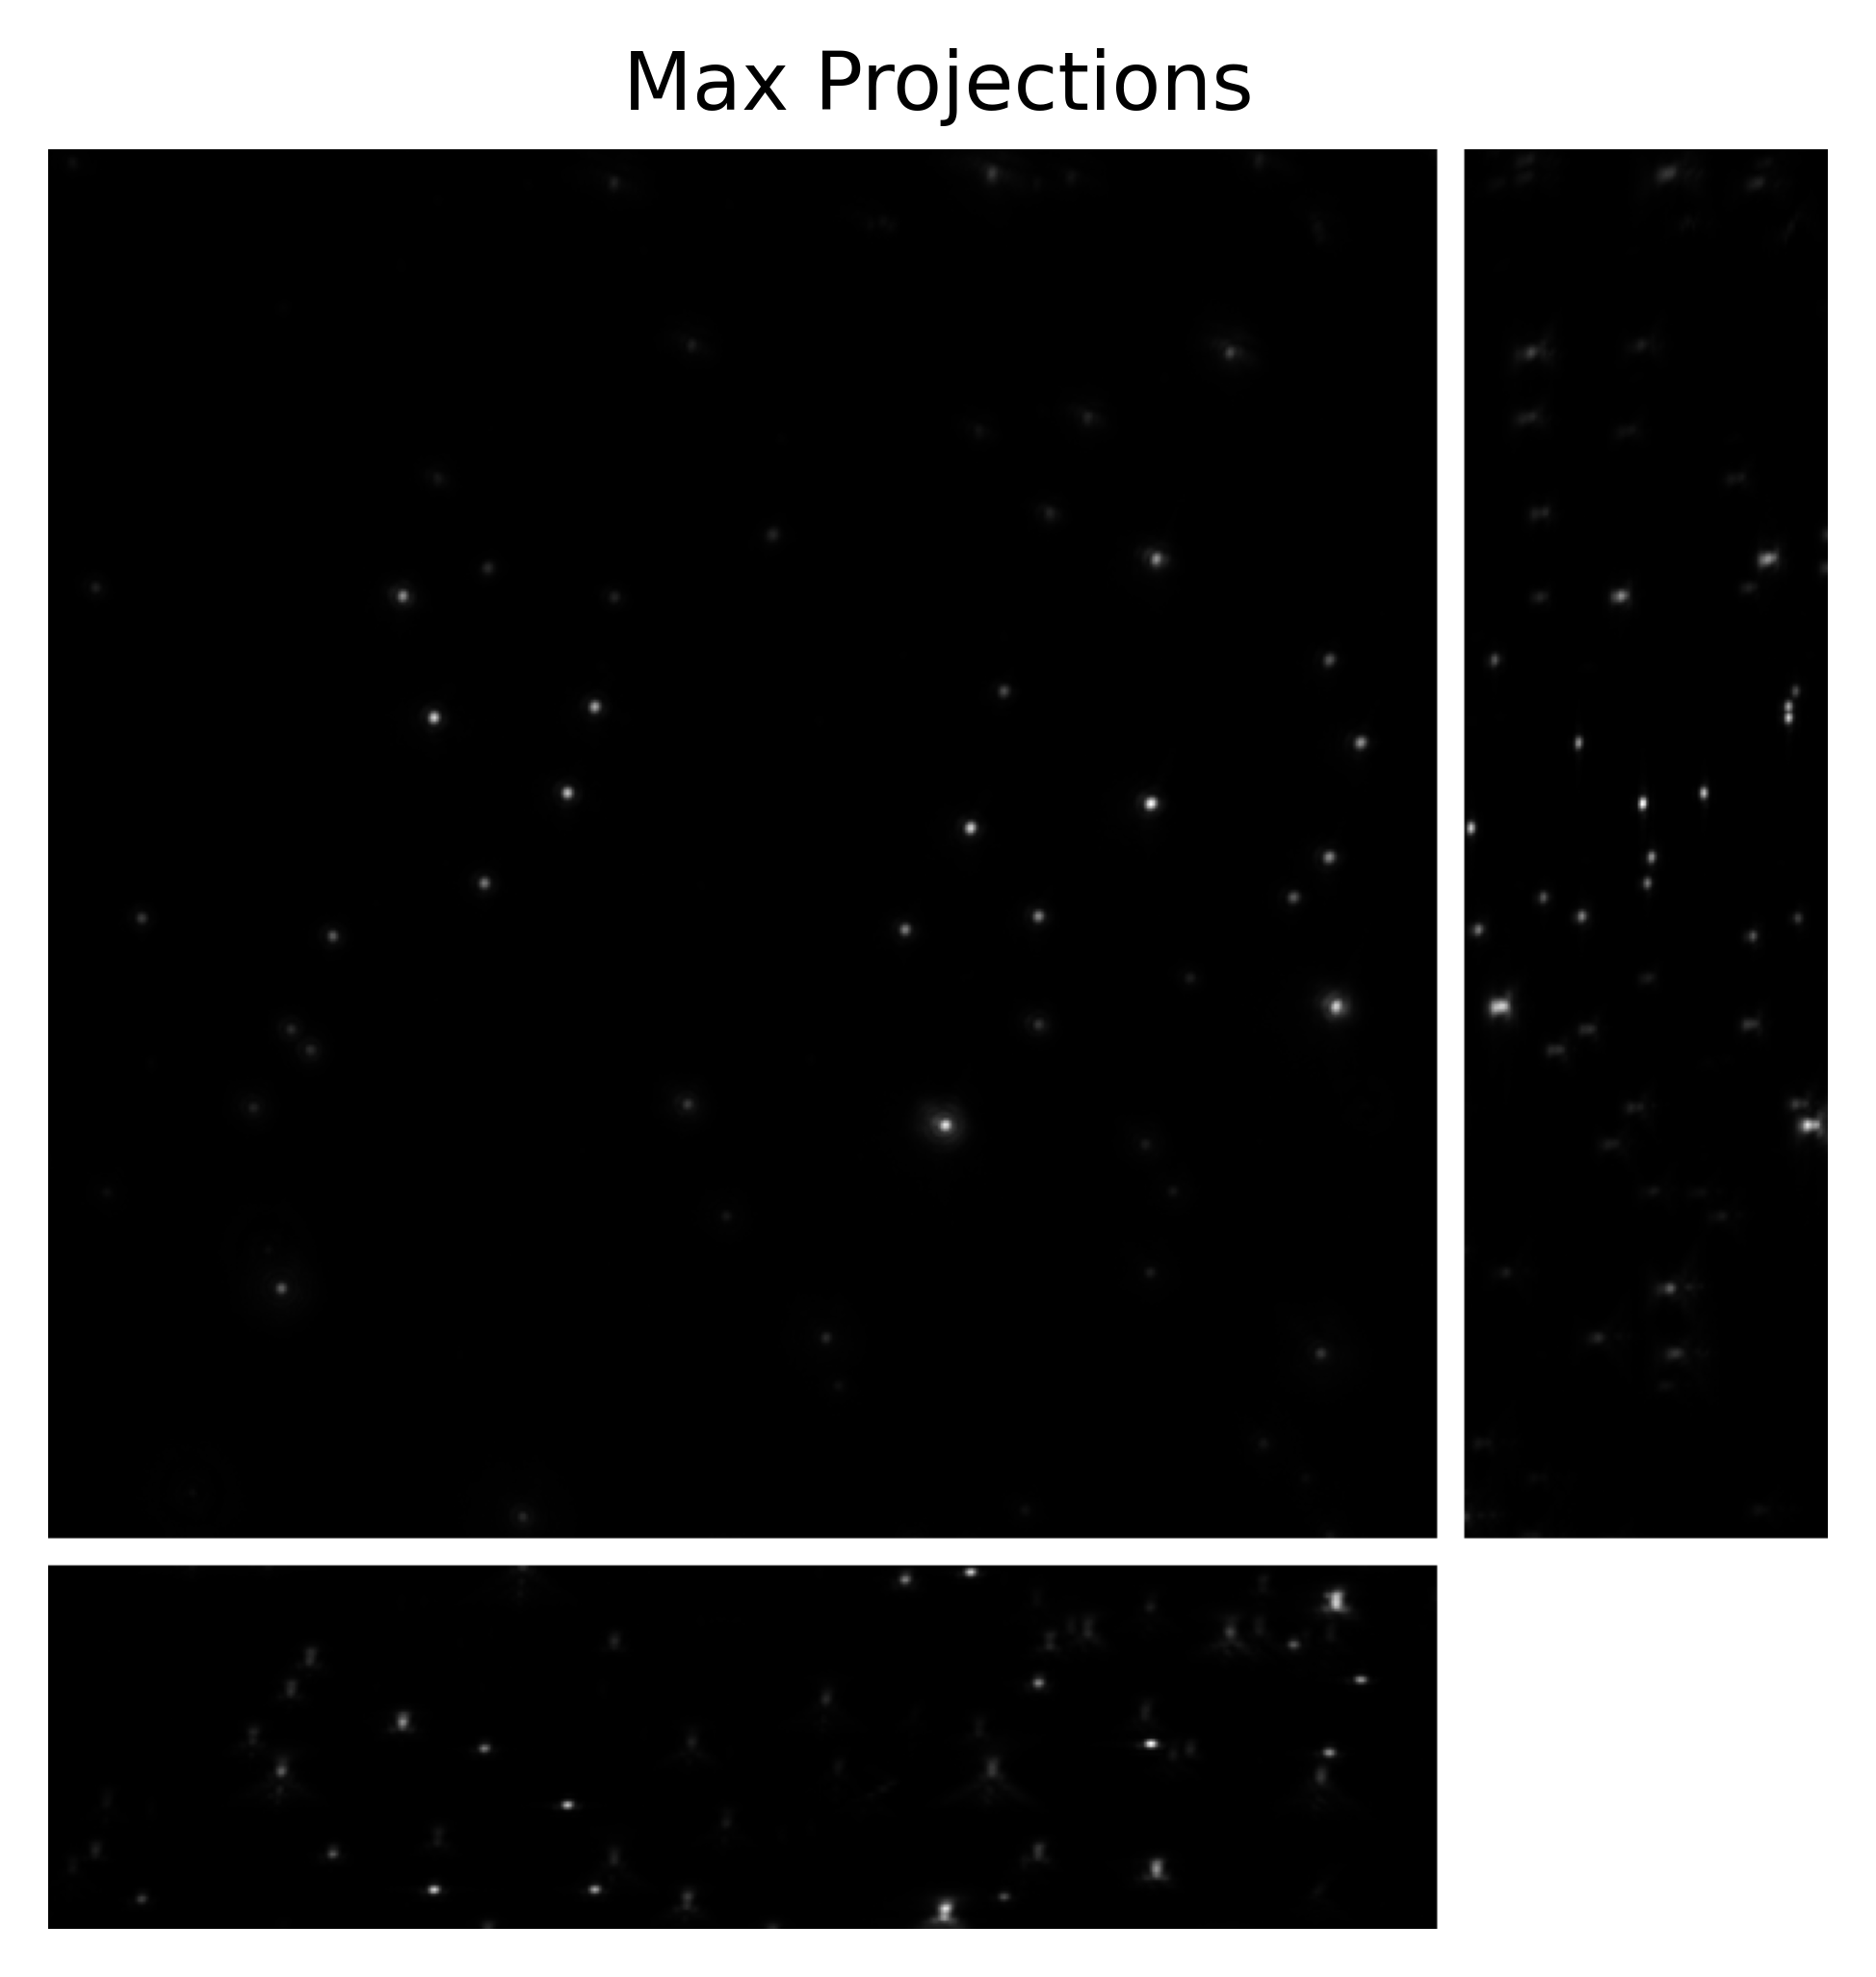

In [8]:
calib_stack = imread(base_dir+"rdm_data/light-sheet/beads/1_CH01_000000.tif")
calib_stack = calib_stack / calib_stack.max()
calib_stack = calib_stack[1, :, :, :].transpose(1, 2, 0)

plot_3d_projections(calib_stack)

Now we calibrate using this stack. For now we will use interpolation model.

In [9]:
psf_cube, psf_locs = rdmpy.calibrate_sdm(
    calib_stack,
    psf_xy_dim=48,
    model="interpolation",
    device=device,
)

Interpolating PSFs...


## Sheet Convolution. 
With some PSFs in hand we can try out sheet convolution at the locations from the calibration image to see how we did!

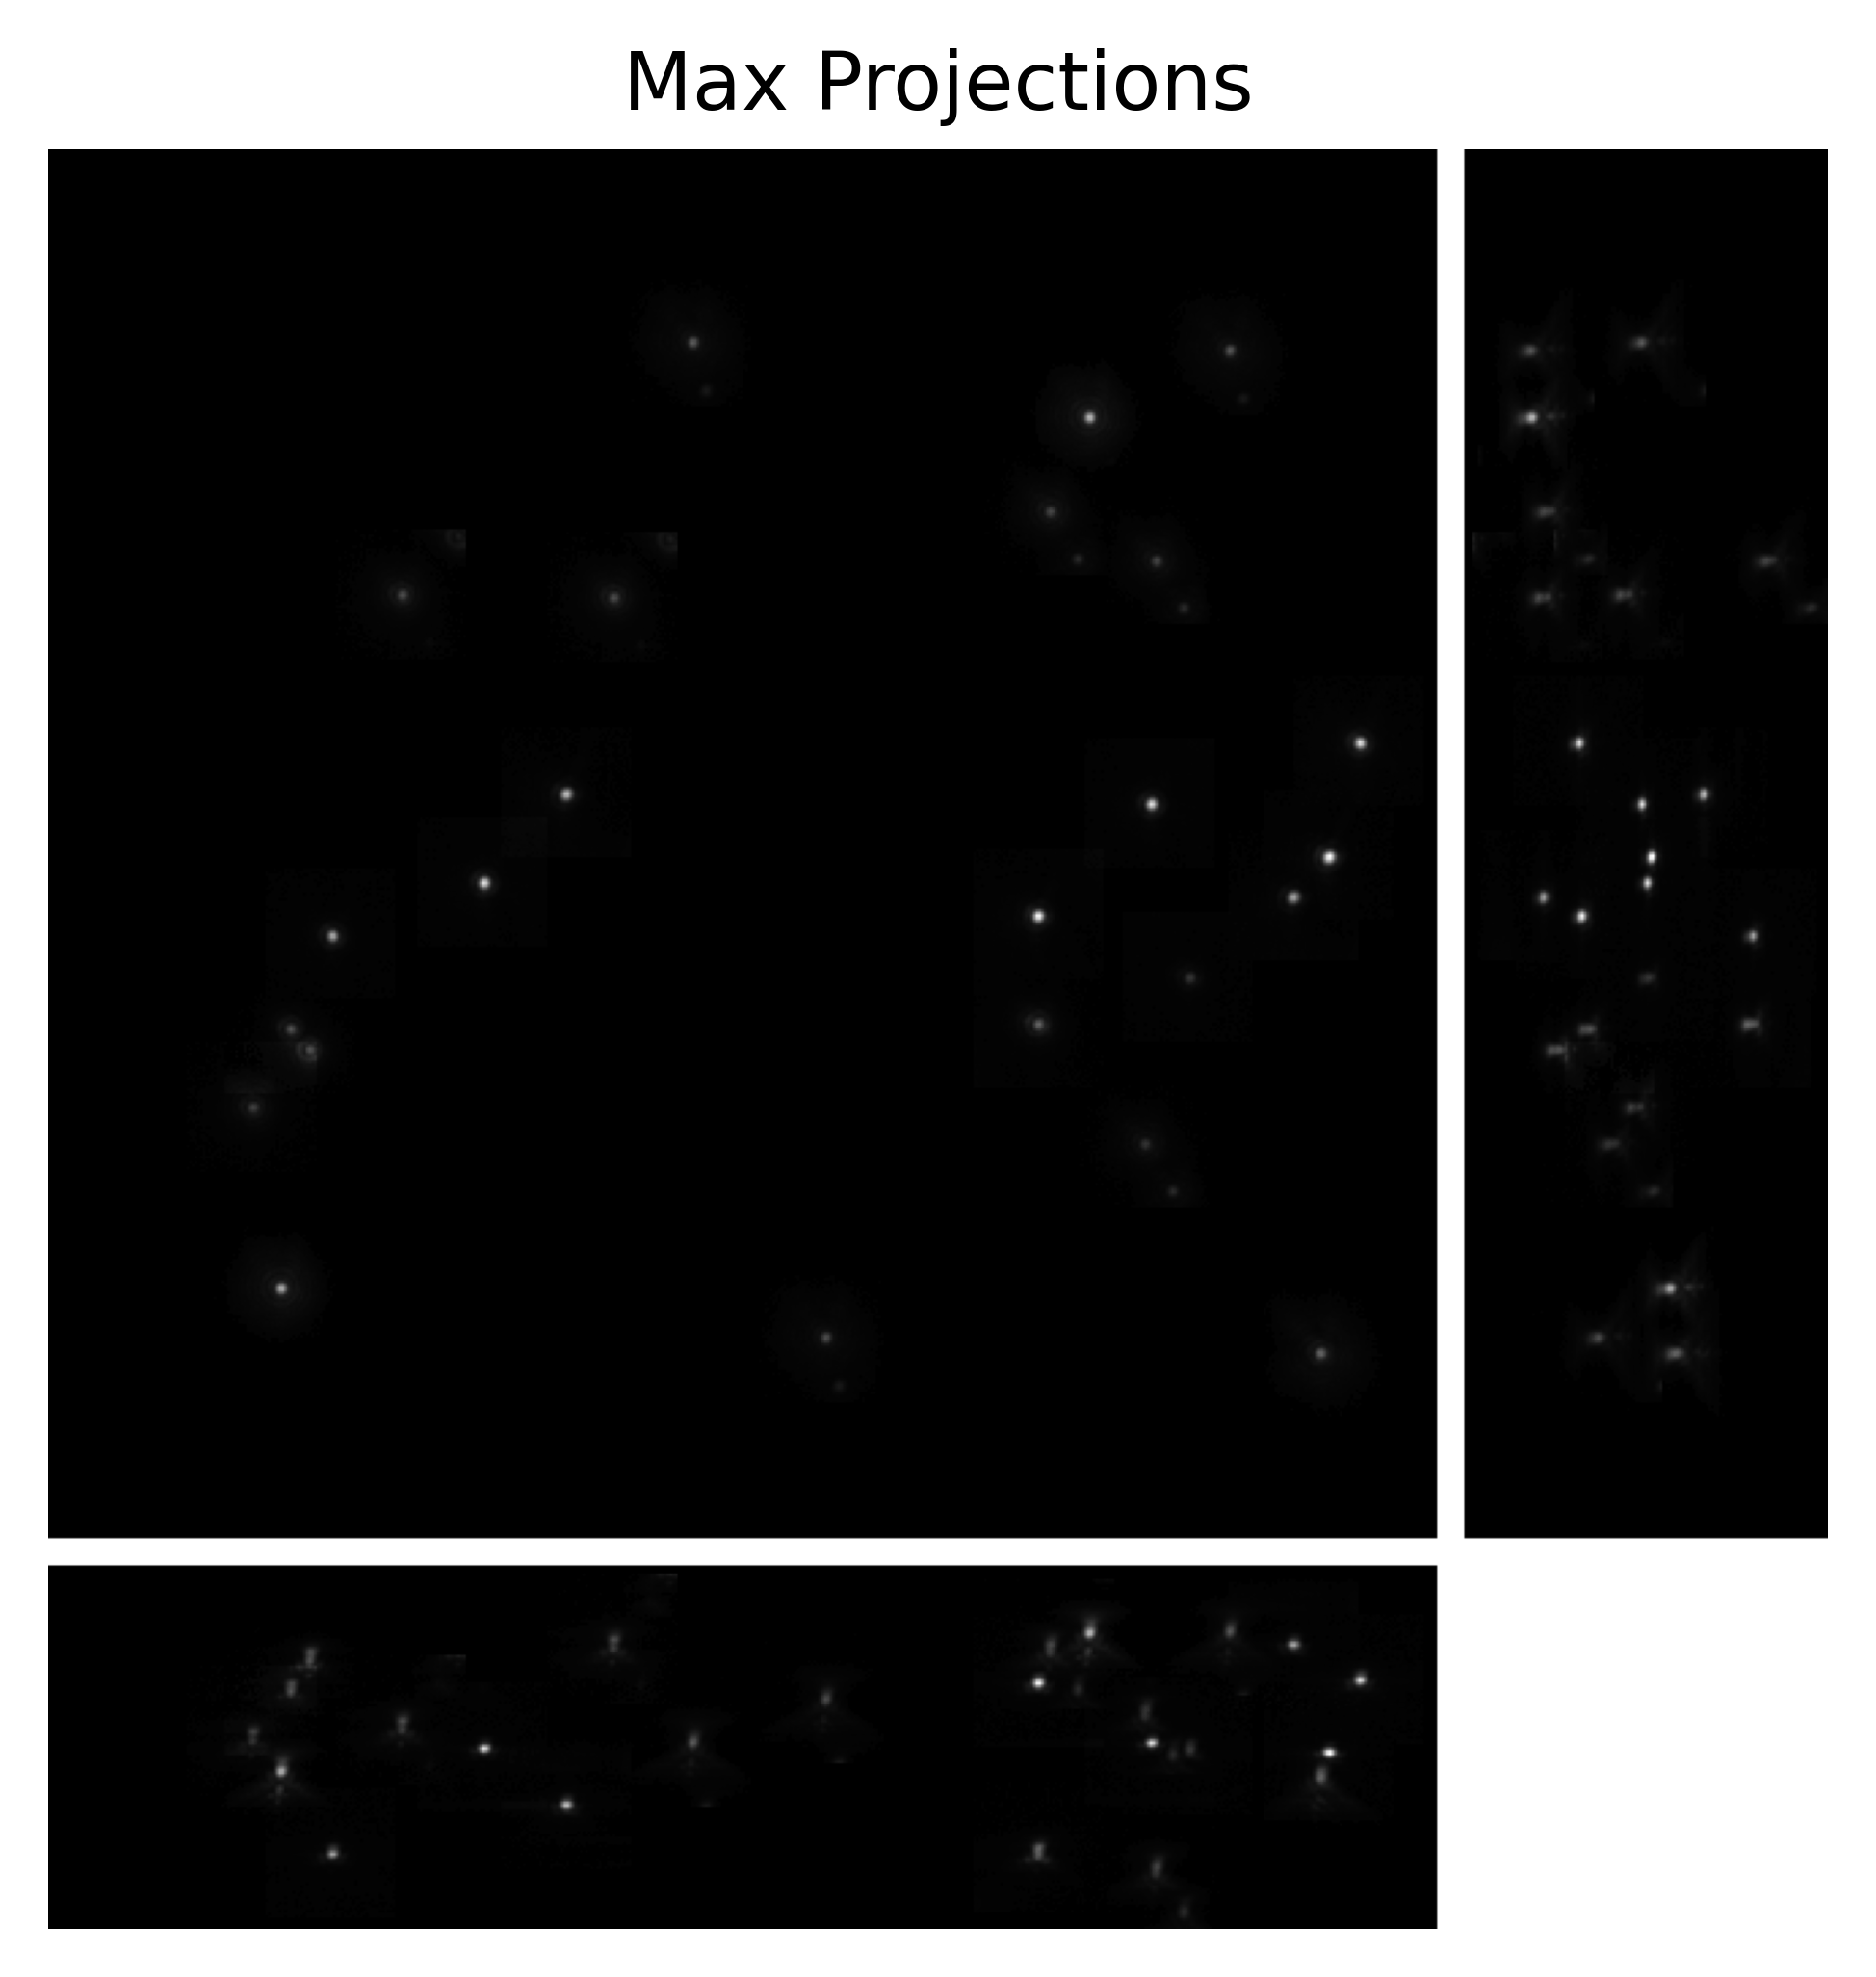

In [10]:
# get a stack of ones as 
#the calibration PSF locations.
test = torch.zeros_like(torch.tensor(calib_stack, device=device)).float()
for loc in psf_locs:
    test[loc[0], loc[1], loc[2]] = 1

# sheet convolve them with our calibrated PSFs to get an estimate of the calibration image.
calib_stack_est = rdmpy.sheet_convolve(test, psf_cube, device=device)
plot_3d_projections((calib_stack_est/calib_stack_est.max()).cpu().numpy())


# Sheet Deconvolution
Now we can see what happpens if we sheet deconvolve the calibration image. Ideally, we'd see a uniform set of beads throughout the FoV!

In [11]:

bead_est = rdmpy.sheet_deconvolve(torch.tensor(calib_stack, device=device).float(), psf_cube, iters=50, lr=1e-2, process=False, device=device)

100%|██████████| 50/50 [03:55<00:00,  4.71s/it]


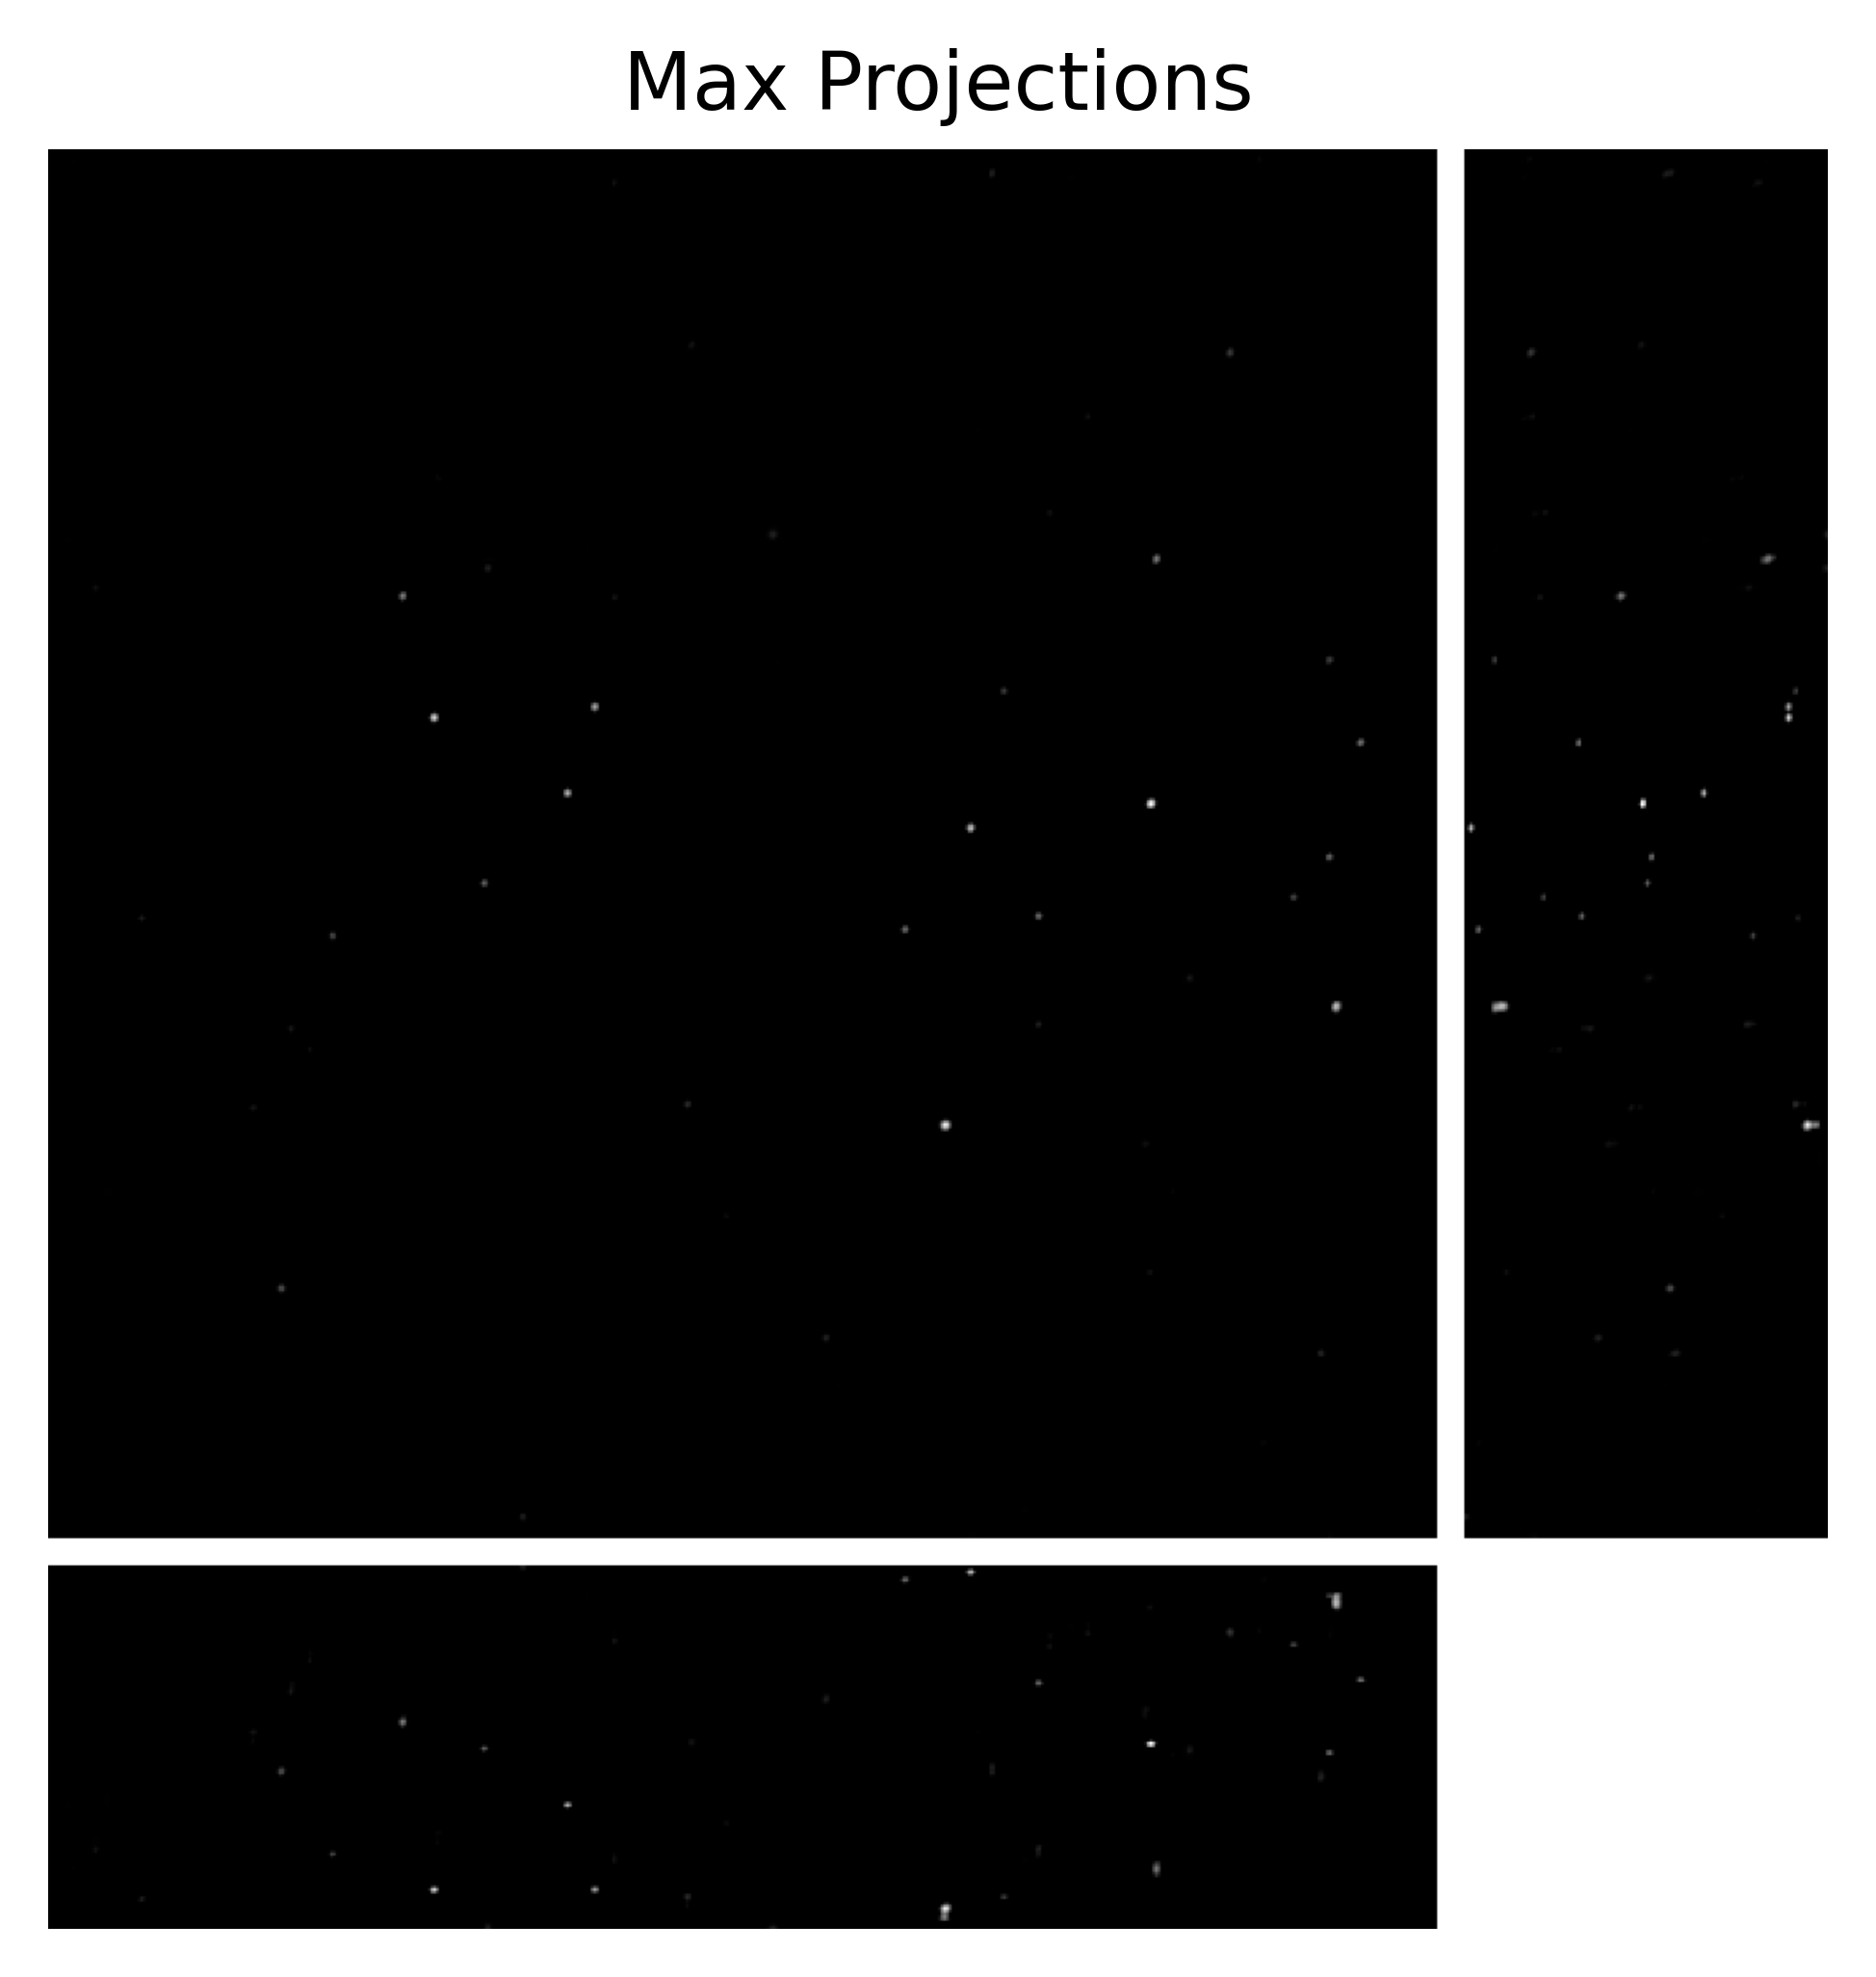

In [12]:
plot_3d_projections((bead_est/bead_est.max()).cpu().numpy(), spacing=10)

## Human pancreatic epithelial cells
Now we can repeat the process for a cell sample. This time we will use the Gibson-Lanni PSF model to help with the noise.


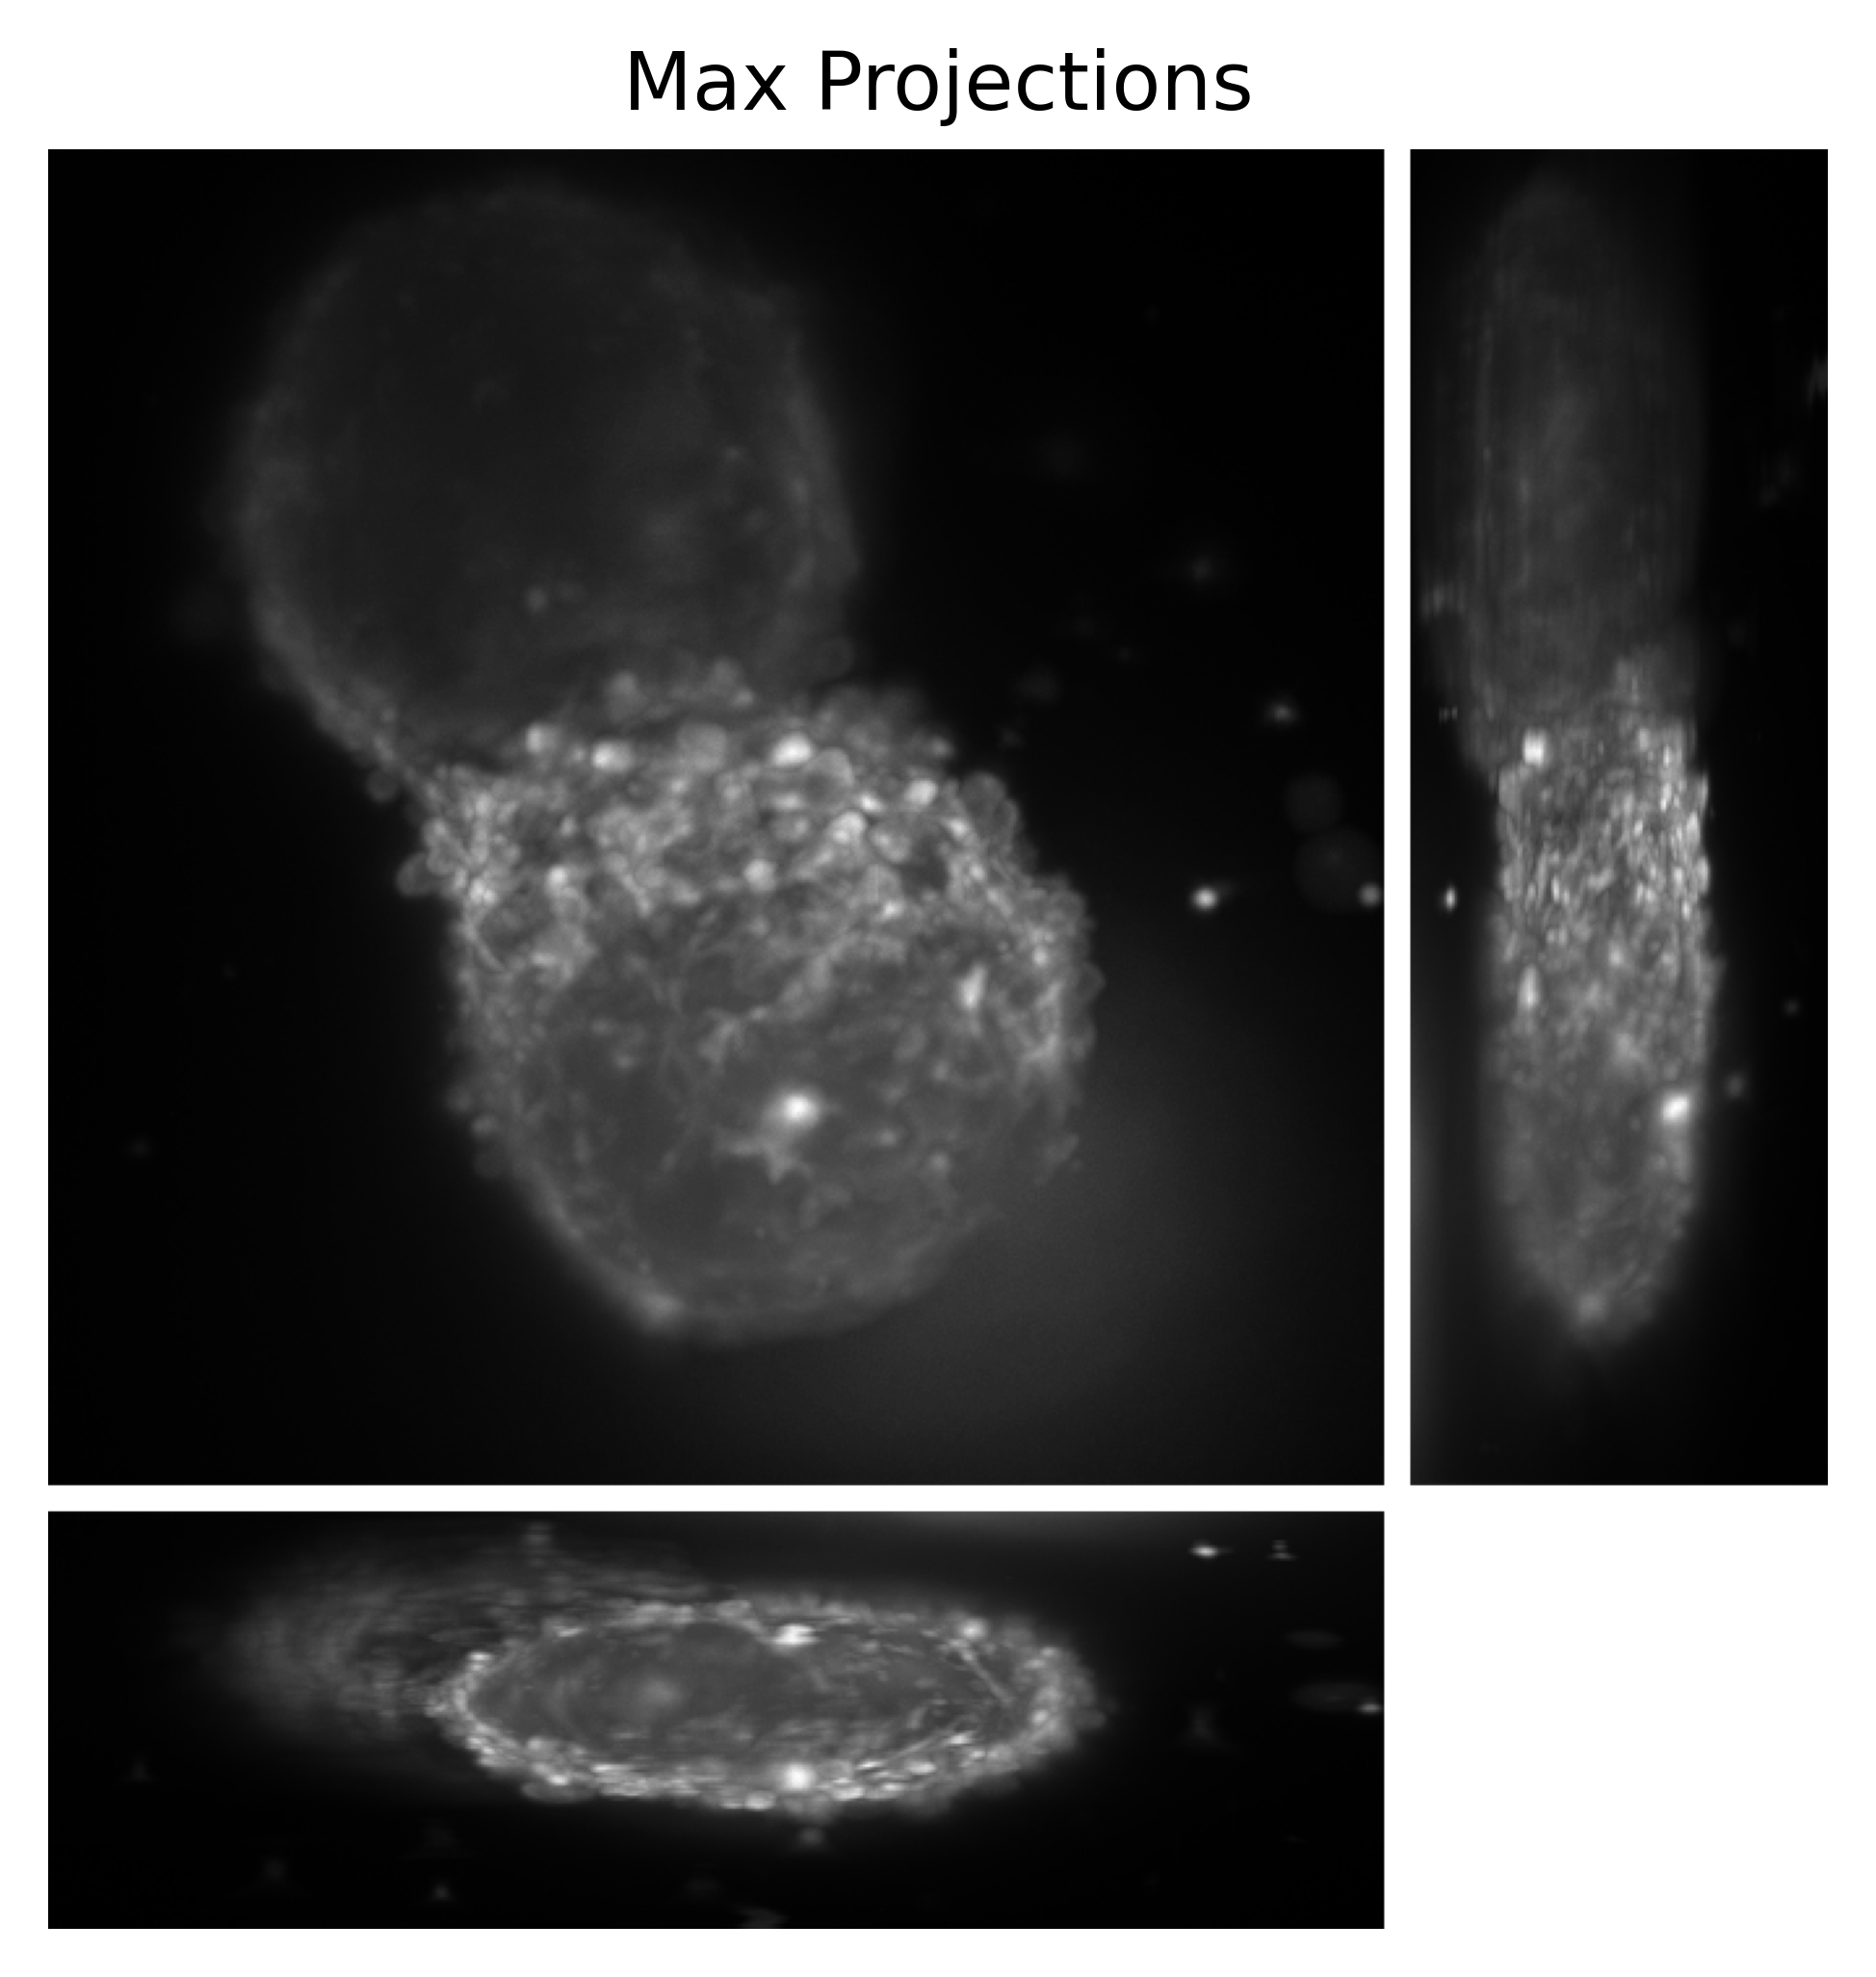

In [13]:
obj = imread(base_dir+"rdm_data/light-sheet/cells/1_CH00_000000.tif")
obj = obj.transpose(1, 2, 0)
obj = block_reduce(obj, (1, 1, 3))
obj = obj[:, :, :-1]
obj = obj - obj.min()
obj = obj / obj.max()
plot_3d_projections(obj)

In [18]:
# Calibration
psf_cube, psf_locs = rdmpy.calibrate_sdm(
    calib_stack,
    psf_xy_dim=64,
    model="gl",
    gl_opt=["dx", "dz"],
    iters=100,
    device=device,
)

Fitting GL model...


100%|██████████| 100/100 [01:24<00:00,  1.19it/s]


waist:  0.28940898180007935
spread:  0.7933060526847839
dx :  0.043803125619888306
dz :  0.35233601927757263


100%|██████████| 256/256 [00:00<00:00, 2980.26it/s]


In [ ]:
# finally let's run sheet deconvolution on the sample (can be slow, run for 300 iters for full convergence)
obj_est = rdmpy.sheet_deconvolve(torch.tensor(obj, device=device).float(), psf_cube, iters=75, lr=1e-1,
    l2_reg=1e-9,
    l1_reg=0,
    tv_reg=5e-12,
    opt_params={"upper_projection": False}, device=device)

100%|██████████| 100/100 [12:12<00:00,  7.33s/it]


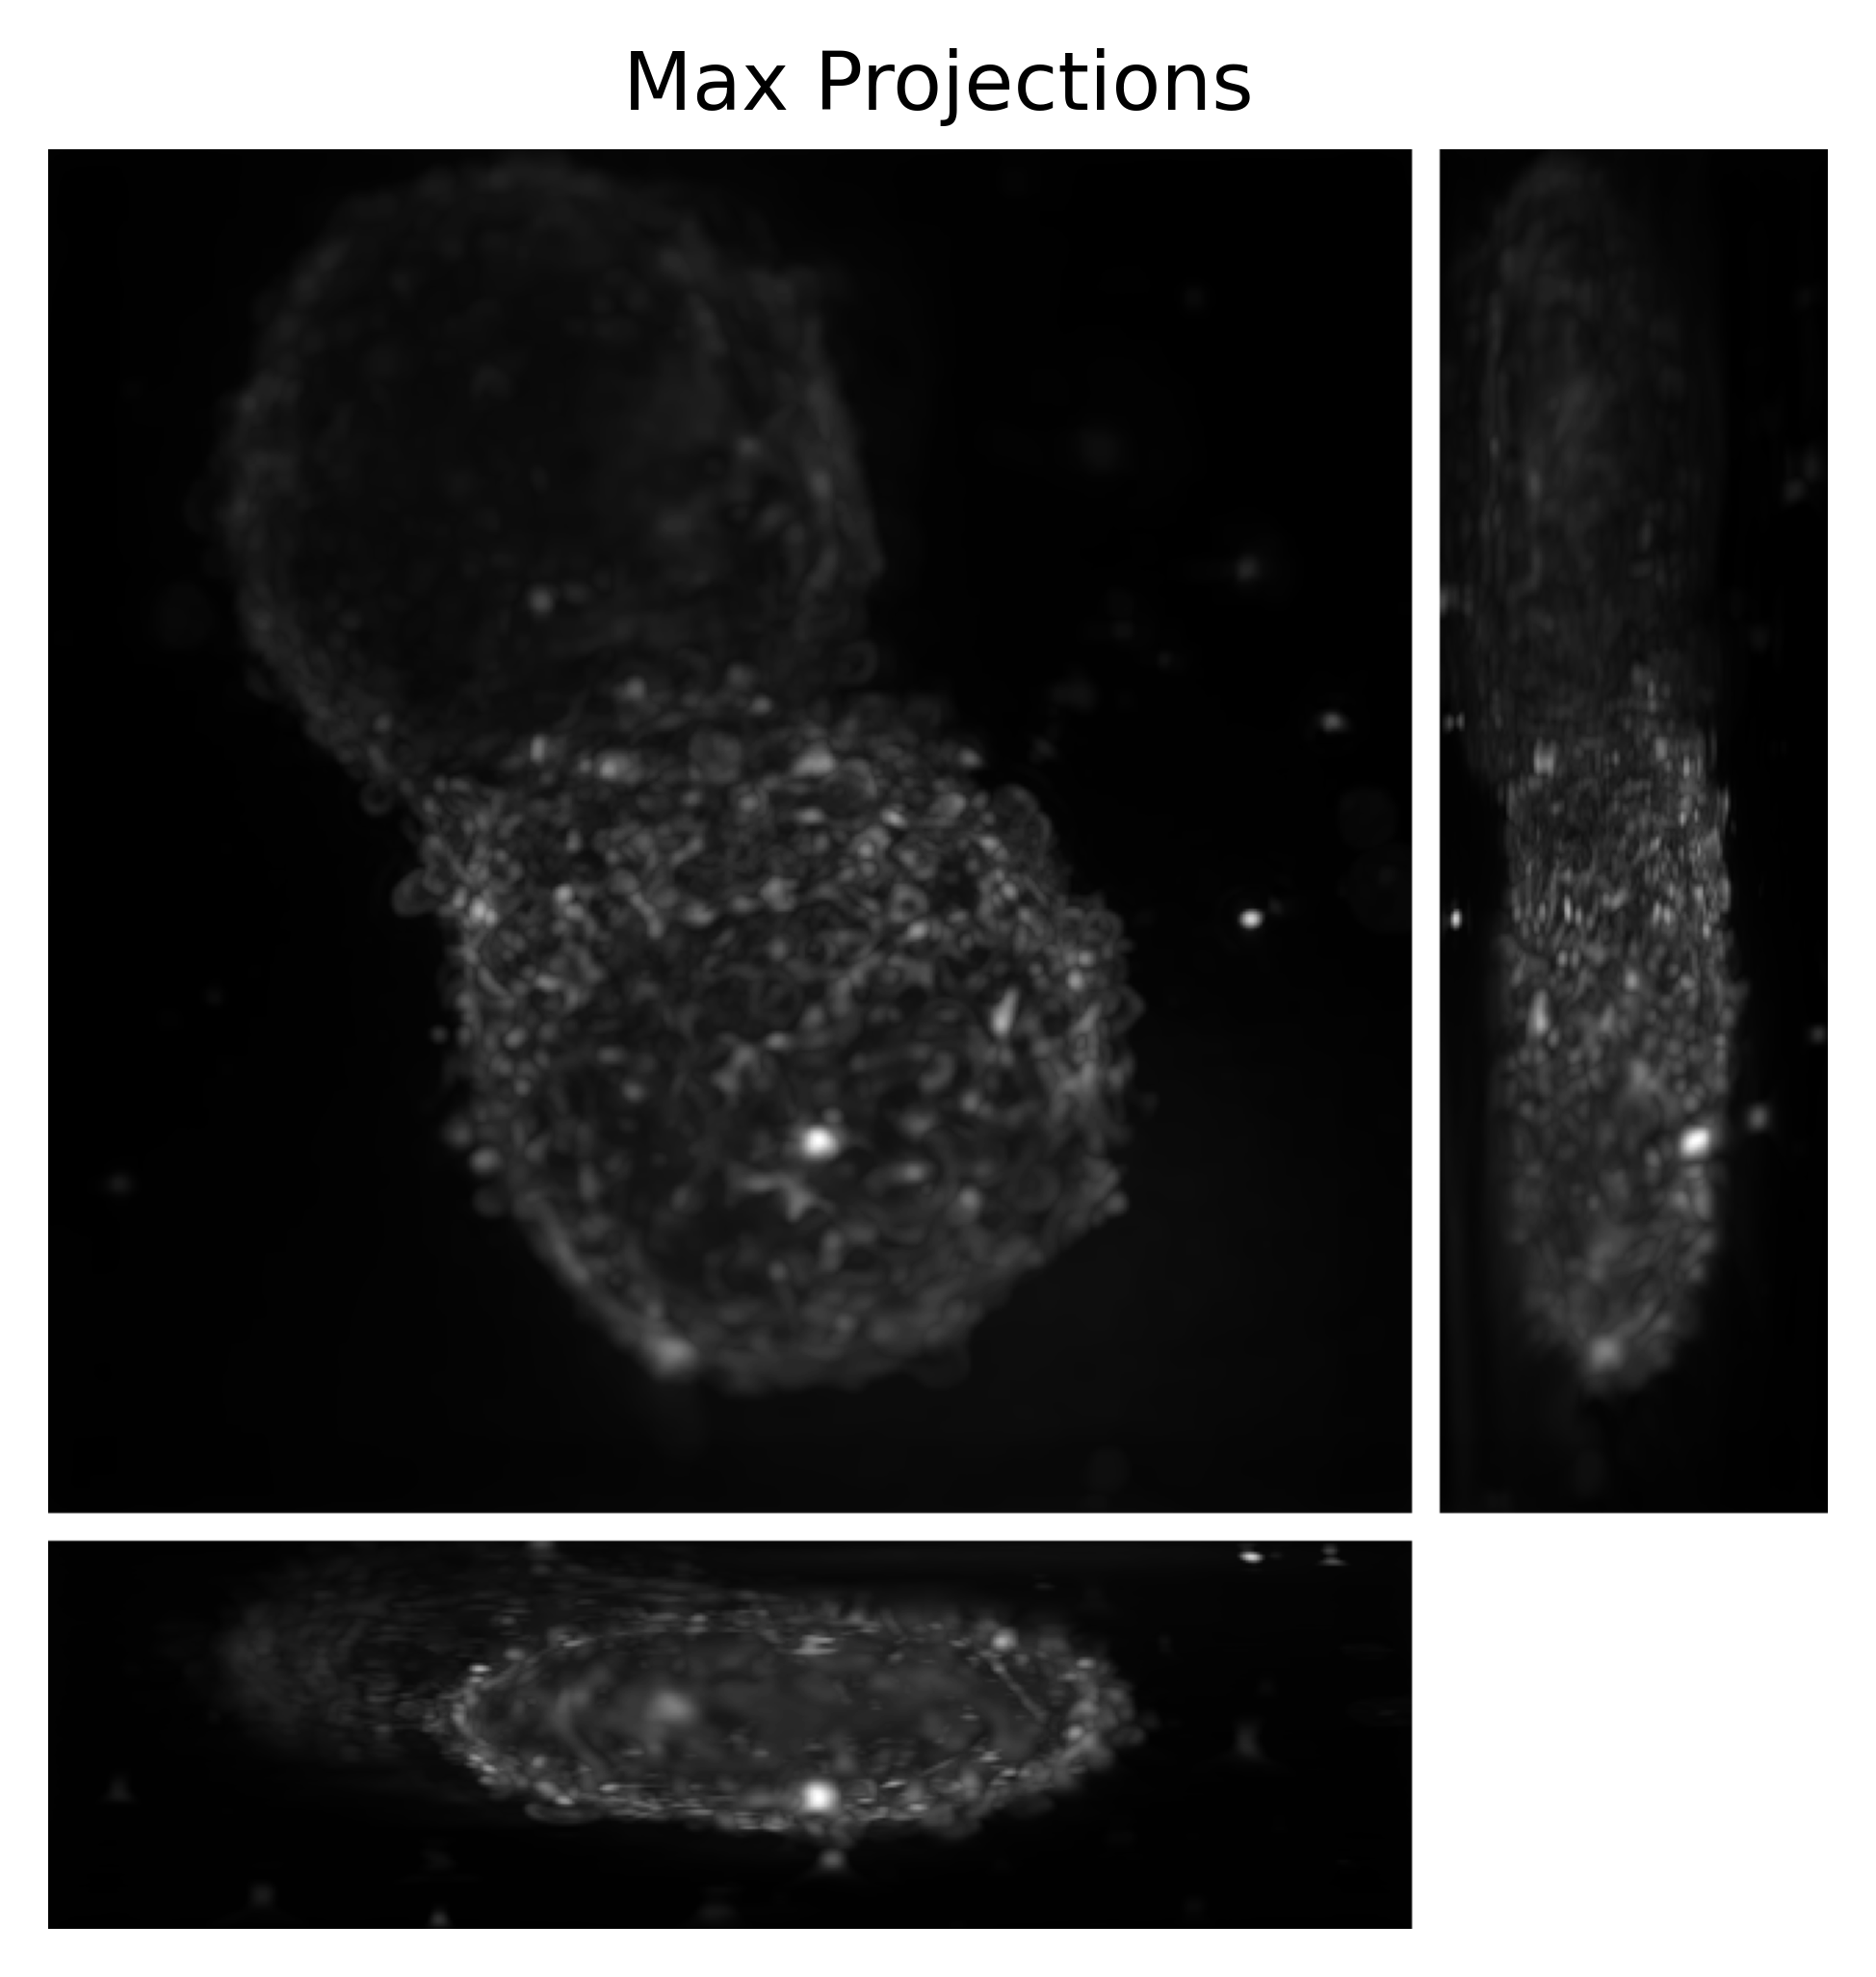

In [24]:
# and plot!
crop=10
plot_3d_projections(((obj_est/obj_est.max())[crop:-crop,crop:-crop,crop:-crop].cpu().numpy()))